In [6]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.compare_models import get_trainer_and_ds_from_saved_trial,get_previous_and_prediction,plot_gain_between_models_with_temporal_agg
from plotting.plotting import get_gain_from_mod1
from plotting.TS_analysis import plot_TS
from examples.train_and_visu_non_recurrent import analysis_on_specific_training_mode
from plotting.plotting import get_df_mase_and_gains,plot_coverage_matshow
from high_level_DL_method import load_optimizer_and_scheduler
from trainer import Trainer

def MASE_visualisation(trainer2,ds2,training_mode,min_flow):
    previous,predict1,predict2,real = get_previous_and_prediction(trainer2,trainer2,ds2,ds2,training_mode)
    dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

    stations = list(ds2.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
    temporal_agg = 'hour'

    fig, axes = plt.subplots(1, 2, figsize=(max(8,0.5*len(stations)),5),gridspec_kw={'width_ratios': [2,5]})
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds2,dic_error,training_mode,temporal_agg,stations)

    # agg All sations  
    plt.sca(axes[0])
    plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_mase1).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
    title = f'Average MASE per {temporal_agg} of Model{1}\nAggregated through stations'
    axes[0].set_title(title) 
    # Per station 
    plt.sca(axes[1])
    plot_coverage_matshow(pd.DataFrame(df_mase1),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
    title = f'Average MASE  per {temporal_agg} of Model{1}'
    axes[1].set_title(title) 

def fine_tune_model(trainer,ds,reduce_lr,freeze,stations_to_plot,training_mode,epochs_fine_tune):
    # Modification: 
    trainer.args.epochs = epochs_fine_tune
    # Reduce LR: 
    if reduce_lr:
       trainer.args.lr =trainer.args.lr/5

    # Freeze weights, excepted the 'output' module : 
    if freeze:
        for name, param in trainer.model.named_parameters(): #model.core_model.named_parameters():
            param.requires_grad = False 
        for name, param in trainer.model.core_model.output.named_parameters():
            param.requires_grad = True  
        # ...

    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(trainer.model,trainer.args)
    trainer_ft = Trainer(ds,trainer.model,trainer.args,optimizer,loss_function,scheduler = scheduler)
    trainer_ft.train_and_valid(normalizer =ds.normalizer)

    analysis_on_specific_training_mode(trainer_ft,ds,training_mode,station = stations_to_plot)
    return trainer_ft


def plot_compare_fine_tune_and_init(trainer1,trainer2,ds1,ds2,stations_to_plot,training_mode,title):
    spatial_units  = list(ds2.spatial_unit)
    station_indices = [spatial_units.index(station) for station in stations_to_plot]
    predict,Y_true,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)
    predict_init,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    df_pred_fine_tuned = pd.DataFrame({f'{spatial_units[station_i]}_Pred_fine_tuned':predict[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_pred =  pd.DataFrame({f'{spatial_units[station_i]}_Pred':predict_init[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_time_series = pd.DataFrame({f'{spatial_units[station_i]}_Y_true': Y_true[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_time_series = pd.concat([df_time_series,df_pred_fine_tuned,df_pred],axis=1)
    df_time_series.index = ds1.tensor_limits_keeper.df_verif_test.iloc[:,-1].values
    plot_TS(df_time_series,width=1400,height=400,bool_show=True,title=title)


# Fine Tuning on the augmmented dataset:
### Load Trained Model and Datasets

In [2]:
modification = {'shuffle':True,
                'DA_method' : ['magnitude_warping','rich_interpolation'],#,'rich_interpolation','magnitude_warping'], #'magnitude_warping',
                'data_augmentation' : True,
                'DA_moment_to_focus' : [{'hours':[0],'weekdays':[0,1,2,3,4,5,6]}],
                'DA_magnitude_max_scale':0.075
                }


save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'

if True: 
    add_name_id2 = 'NETMOB_POIS_maps_Deezer_concat_early_DL_IRIS'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 

if False: 
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 

if False:
    add_name_id2 = ''
    trial_id2 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'

trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder,modification)

# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Custom POIs associated by stations:  ['AMP: 20', 'BEL: 22', 'BRO: 24', 'COR: 28', 'CUI: 60', 'CUS: 18', 'FLA: 28', 'GOR: 32', 'BLA: 20', 'GRA: 49', 'GUI: 28', 'GIL: 31', 'HEN: 31', 'HOT: 32', 'LAE: 20', 'MAS: 23', 'MER: 23', 'LUM: 28', 'PRY: 16', 'PER: 24', 'SAN: 24', 'SAX: 29', 'VMY: 13', 'JEA: 21', 'BON: 25', 'CHA: 25', 'VAI: 28', 'VEN: 58', 'MAC: 21', 'GAR: 25', 'FOC: 27', 'REP: 38', 'GER: 11', 'DEB: 18', 'JAU: 15', 'CPA: 32', 'CRO: 32', 'PAR: 25', 'SOI: 37', 'OGA: 51']
vision_input_type POIs
vision_model_name VariableSelectionNetwork
160 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([3141, 40, 7]) torch.Size([3141, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/

## Analysing Moments which are not correctly predicted: 

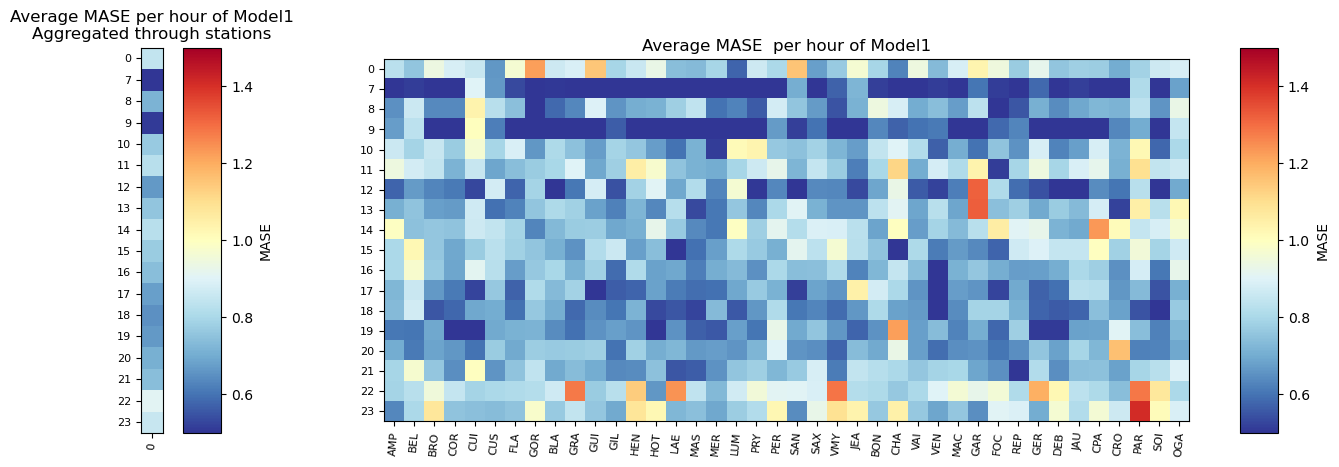

In [3]:
MASE_visualisation(trainer2,ds2,training_mode,min_flow)

### Fine Tuning
- Baisser le learning rate 
- Freeze certaines couches
- On peut aussi pénaliser les écart trop important par rapport aux poids initiaux

In [7]:
freeze = False
reduce_lr = True 

epochs_fine_tune =  10
stations_to_plot = ['CHA','PER','PAR']
training_mode = 'test'

trainer2_ft = fine_tune_model(trainer2,ds2,reduce_lr,freeze,stations_to_plot,training_mode,epochs_fine_tune)


start training



Training Throughput:94.19 sequences per seconds
>>> Training complete in: 0:07:07.325313
>>> Training performance time: min 0.06244516372680664 avg 0.09386825561523438 seconds (+/- 0.3543139807119392)
>>> Loading performance time: min 0.002638101577758789 avg 0.21786634015365386 seconds (+/- 2.5093744417945523)
>>> Forward performance time: 0.21095301167186278 seconds (+/- 0.2750558913505156)
>>> Backward performance time: 0.08380481302436851 seconds (+/- 0.09430139463902008)
>>> Plotting performance time: 3.417332967122396e-06 seconds (+/- 1.0543266265727362e-06)
>>> Saving performance time: 2.133373975753784 seconds (+/- 2.1158294677734375)
>>> PI-tracking performance time: 1.7537011040581598e-05 seconds (+/- 1.6055921773925026e-05)
>>> Scheduler-update performance time: 7.2320302327473956e-06 seconds (+/- 5.374857082020733e-06)
>>> Peak Power during training: 120.621 W)
>>> Validation time: 0:00:00.881909
Proportion of time consumed for Loading: 38.0%
Proportion of time consumed fo

Loading BokehJS ...

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Custom POIs associated by stations:  ['AMP: 20', 'BEL: 22', 'BRO: 24', 'COR: 28', 'CUI: 60', 'CUS: 18', 'FLA: 28', 'GOR: 32', 'BLA: 20', 'GRA: 49', 'GUI: 28', 'GIL: 31', 'HEN: 31', 'HOT: 32', 'LAE: 20', 'MAS: 23', 'MER: 23', 'LUM: 28', 'PRY: 16', 'PER: 24', 'SAN: 24', 'SAX: 29', 'VMY: 13', 'JEA: 21', 'BON: 25', 'CHA: 25', 'VAI: 28', 'VEN: 58', 'MAC: 21', 'GAR: 25', 'FOC: 27', 'REP: 38', 'GER: 11', 'DEB: 18', 'JAU: 15', 'CPA: 32', 'CRO: 32', 'PAR: 25', 'SOI: 37', 'OGA: 51']
vision_input_type POIs
vision_model_name VariableSelectionNetwork
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size(

Loading BokehJS ...

figure(id='p1827', ...)

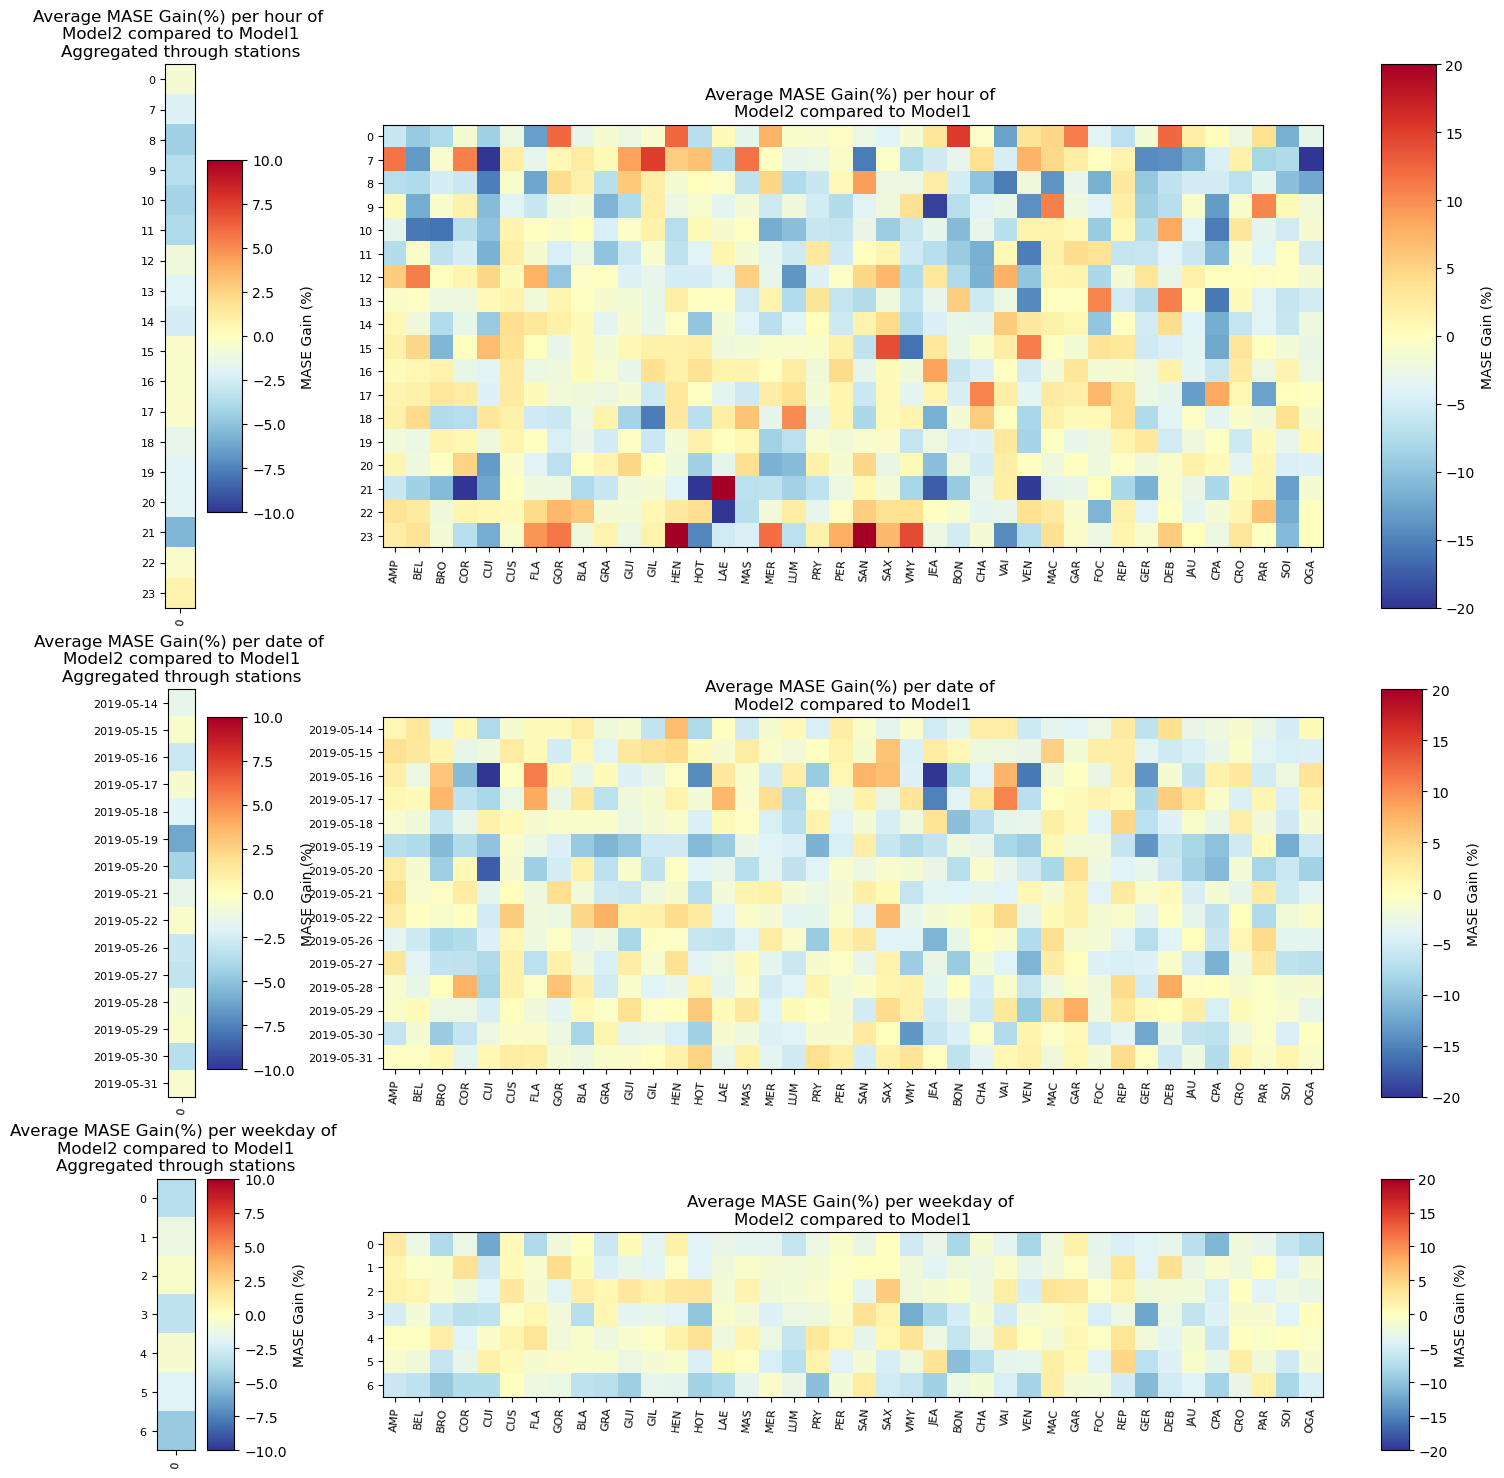

In [9]:
# Load Trained Model with no fine-tuning:
modification = {'shuffle':False,
                'data_augmentation' : False,
                }

if False:
    add_name_id_ref = ''
    trial_id_ref ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
if True: 
    add_name_id_ref = add_name_id2
    trial_id_ref =trial_id2 

trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id_ref,add_name_id_ref,save_folder,modification)


previous,predict1,predict2,real = get_previous_and_prediction(trainer1,trainer2_ft,ds1,ds2,training_mode)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)

plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)


plot_compare_fine_tune_and_init(trainer1,trainer2_ft,ds1,ds2,stations_to_plot,training_mode,title=f"Comparaison before/after fine tuning")

## Analyse MASE after fine-tuning : 

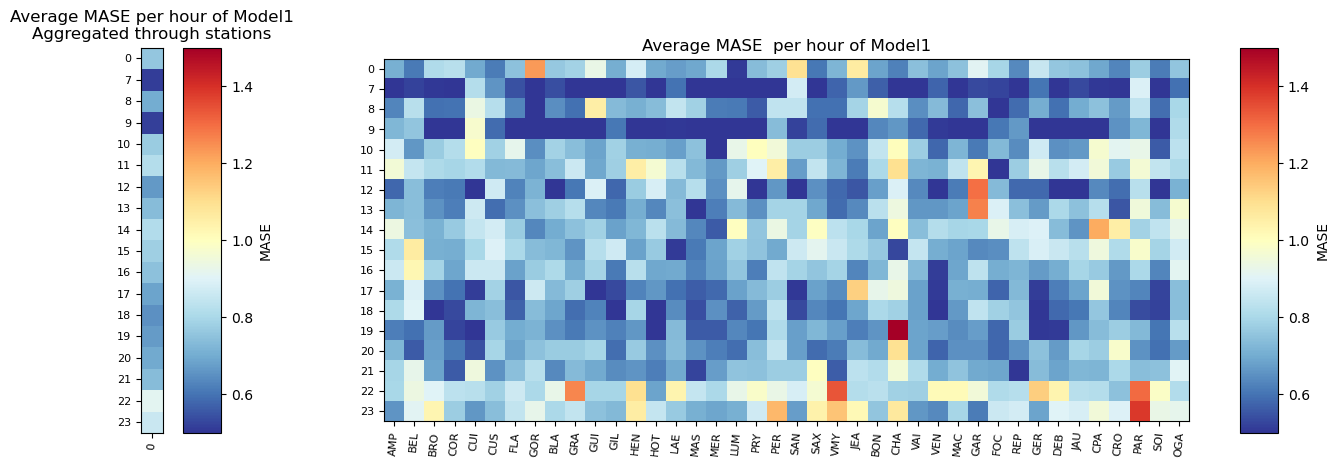

In [41]:
MASE_visualisation(trainer2_ft,ds2,training_mode,min_flow)